Geocoding Quality Analysis

Checks the X,Y of google maps api versuse the XY for records matching in the permit database

In [24]:
import geopandas as gpd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fiona as fio
import shapely as shp  



In [44]:
df = pd.read_csv("../data/csv/ar_samples_merged_xy.csv")

In [45]:
# Create two point datasets for those that have BOTH original X Y and geocoded X Y, 
# This is because they likely have different coordinate systems.
# Once they have the same coordinate system, distance between the original XY and geocoded XY points will be analyzed

df = df[df['X'].notnull()]

ar = df[['id','full_add','group','X','Y']]
alt = df[['id','full_add','group','geoX','geoY']]


In [46]:
print(len(ar))
print(len(alt))

718
718


In [47]:

# Convert both to geodataframes

ar = gpd.GeoDataFrame(ar, geometry=gpd.points_from_xy(ar.X, ar.Y), crs = "EPSG:4269")

# specify the coordinate system for google maps output (WGS84)
alt = gpd.GeoDataFrame(alt, geometry=gpd.points_from_xy(alt.geoX, alt.geoY), crs="EPSG:4326")

# change to projected coordinate system (UTM 17N)
alt = alt.to_crs("EPSG:32617")
ar = ar.to_crs("EPSG:32617")



In [48]:
print(ar.crs)
print(alt.crs)

EPSG:32617
EPSG:32617


In [49]:
# using the 'id' column, iterate through each row and calculate the distance between the original X Y and geocoded X Y

dist = []

for i, row in ar.iterrows():
    dist.append(ar.geometry[i].distance(alt.geometry[i]))



In [50]:
df['dist'] = dist

Based on the summary below, theres a few bad records throwing off the mean distance between original and geocoded coordinates. easy to see by looking at the quartiles. S well delete the outliers and recalculate the mean.

In [51]:
df['dist'].describe()

count      718.000000
mean       253.316358
std       1724.887409
min          0.207860
25%          2.419098
50%          4.488756
75%         15.660889
max      24296.581842
Name: dist, dtype: float64

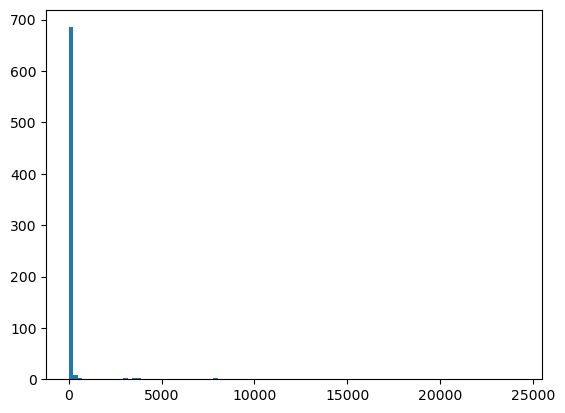

In [52]:
plt.hist(df['dist'], bins=100)
plt.show()

In [53]:
# subset the dataframe to only those that have a distance greater than 100 meters
check = df[df['dist'] > 100]
len(check)

57

In [54]:
# check of these, how many have an original X Y

len(check[check['X'].notnull()])


57

In [57]:
# so we dont have to use the geocoded XY for any of these that are off. 
# but to ensure which source is incorrect well plot on a interactive map that lets you 
# select each point to see the address field for both the original and geocoded

# create a folium map

import folium

m = folium.Map(location=[35.3, -81.2], zoom_start=5)

# create a feature group for each dataset

ar_fg = folium.FeatureGroup(name="AR")

alt_fg = folium.FeatureGroup(name="Alt")

# iterate through each row in the dataframe and add a marker to the map

for i, row in check.iterrows():
    ar_fg.add_child(folium.Marker(location=[row['Y'], row['X']], popup=row['full_add'],
                                                icon=folium.Icon(color="blue", icon="crosshairs", prefix='fa')))


    alt_fg.add_child(folium.Marker(location=[row['geoY'], row['geoX']], popup=row['full_add'],
                                                icon=folium.Icon(color="red", icon="crosshairs", prefix='fa')))

# add the feature groups to the map

m.add_child(ar_fg)
m.add_child(alt_fg)

# add a layer control to the map

folium.LayerControl().add_to(m)

# save the map

#m.save("../data/alt/gis/point/ar_samples.html")

m